# CEE 690-02

# Environmental Spatial Data Analysis

# Feature Engineering and Selection

# Dataset: EUROSAT

![image.png](https://github.com/phelber/EuroSAT/raw/master/eurosat_overview_small.jpg?raw=true)

* 27,000 labeled and geo-referenced images with 13 spectral bands from Sentinel-2
* Each image covers a 640 m by 640 m domain at a 10 meter spatial resolution. 
* The images are a collection of sites around Europe
* Each image has been prelabeled a given land use class (e.g., Forest).
* This dataset can be used to construct models to predict land use from Sentinel-2 data

For more info go here: https://github.com/phelber/eurosat

Before we go any further, it's time we learn a little bit of basic remote sensing

# Sentinel-2 

![image.png](https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2011/11/sentinel-2/10202548-2-eng-GB/Sentinel-2_pillars.jpg)

# Video time!

https://www.youtube.com/watch?v=Bv3pB9TaWOk

# Sentinel-2 spectral bands

![image.png](https://eo4geo.sbg.ac.at/IGIK/Sentinel2_Data_and_Vegetation_Indices/S2-2020_ESA.jpeg)

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import pickle
import scipy.stats

In [2]:
db = pickle.load(open('/data/ds/images/remote_sensing/otherDatasets/sentinel_2_subset.pck','rb'))
y = db['obs']['lc_id'][:]

Let's see what the data looks like for a given domain

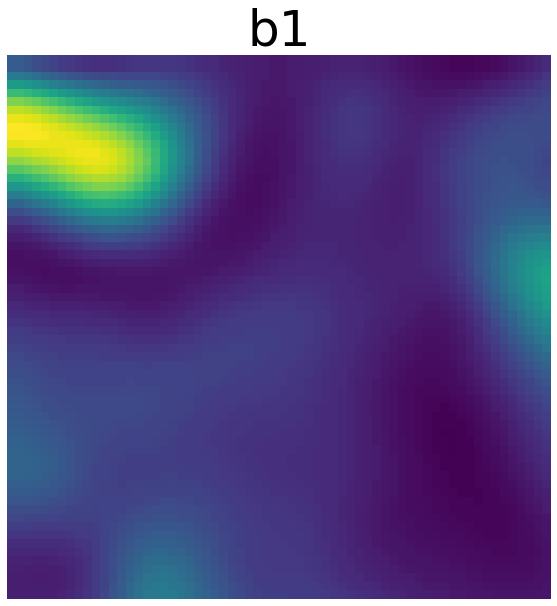

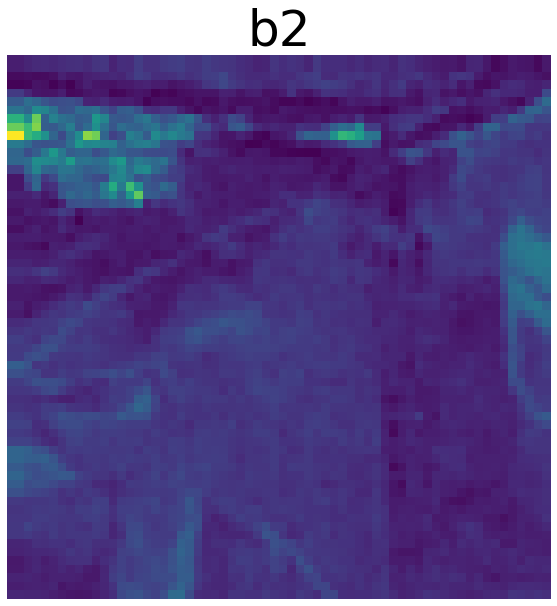

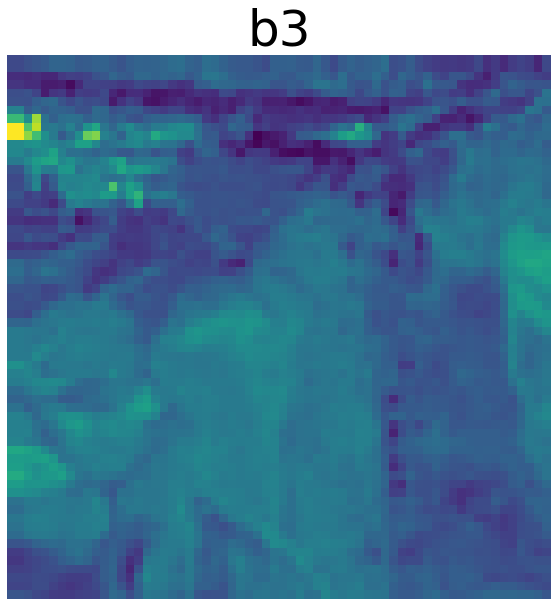

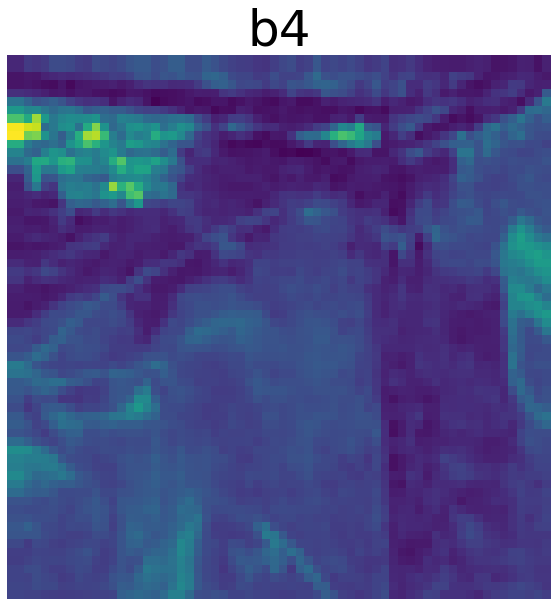

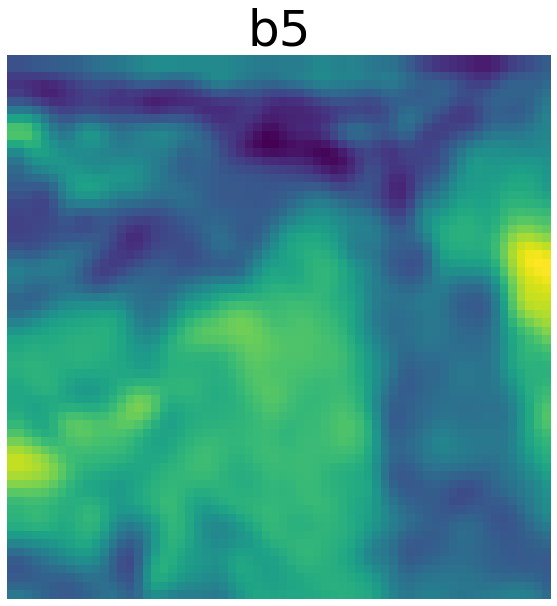

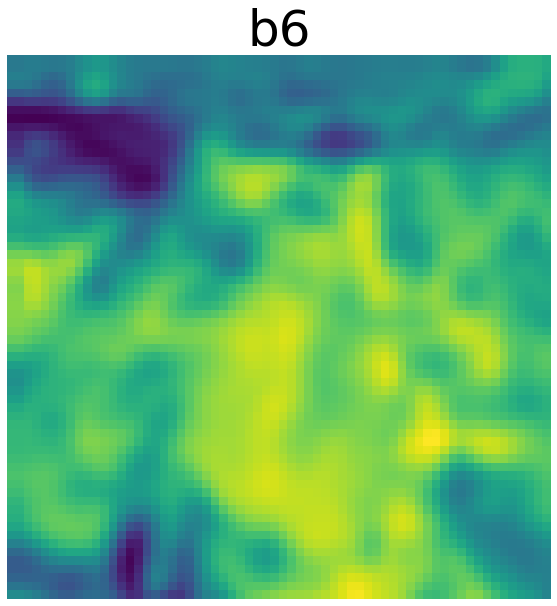

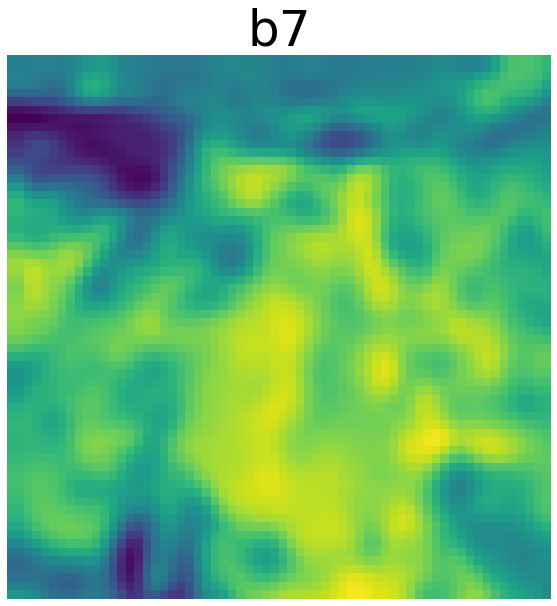

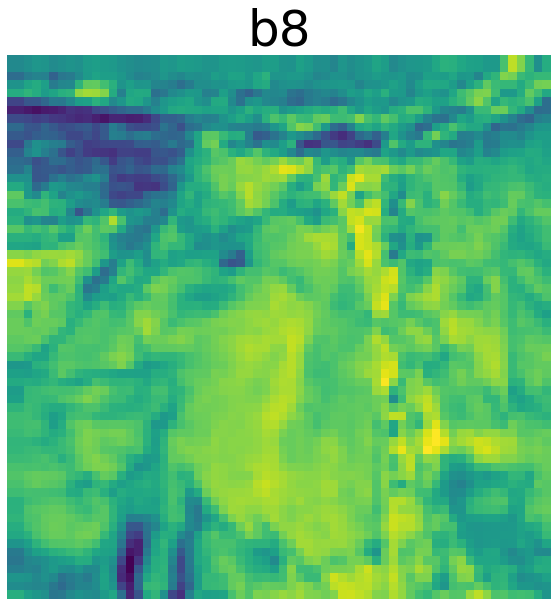

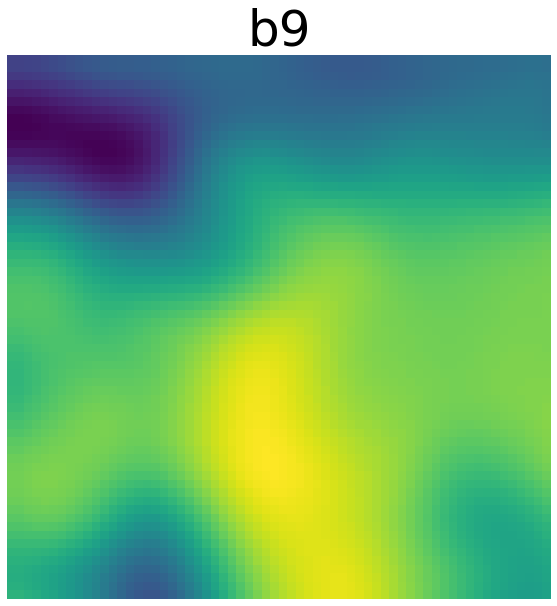

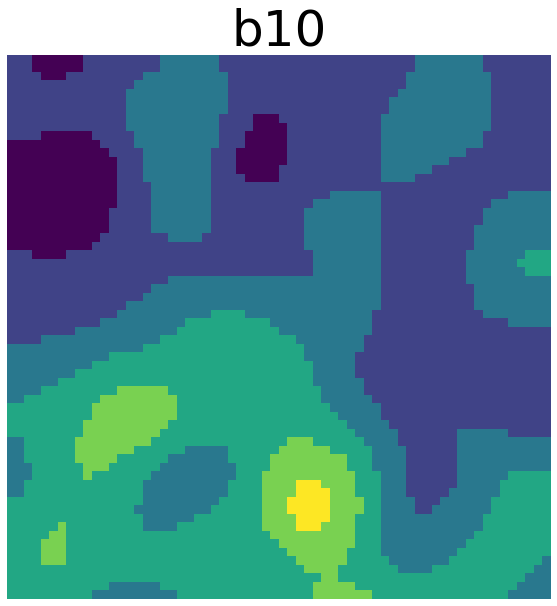

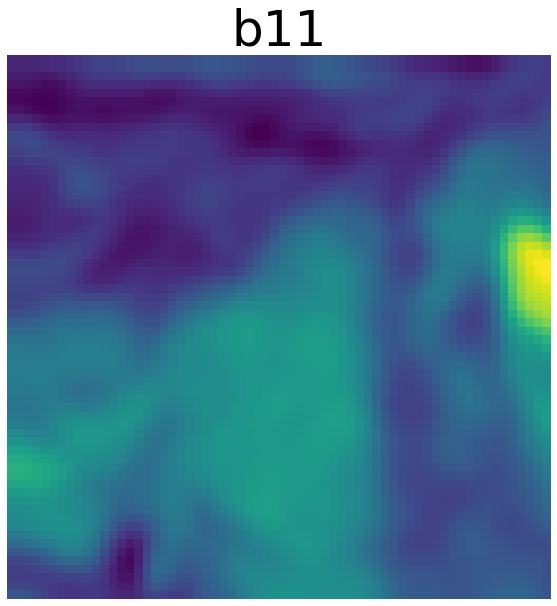

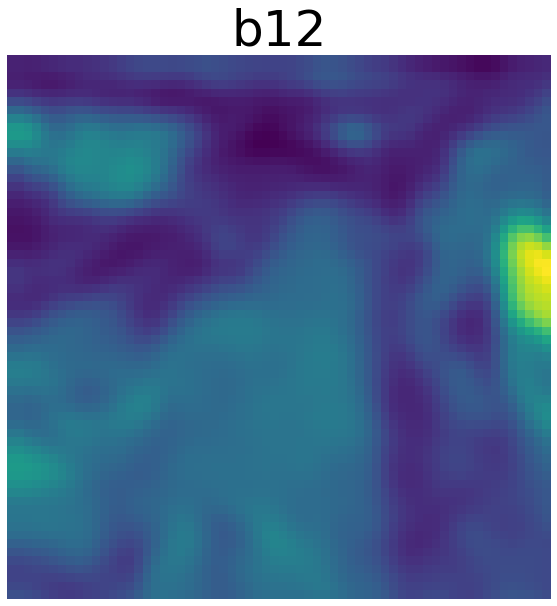

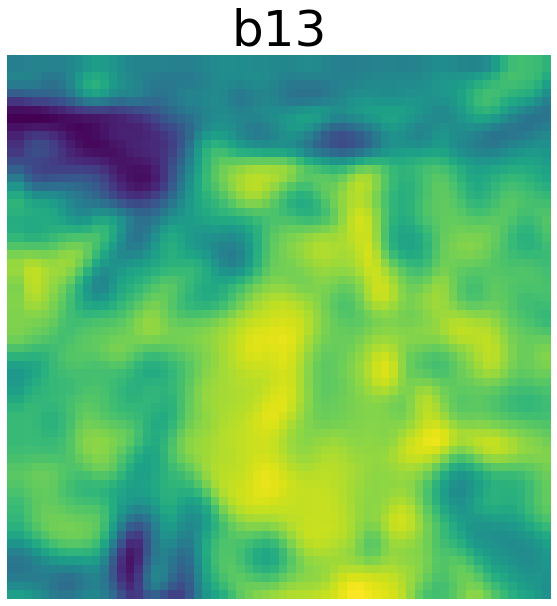

In [3]:
for var in db['covariates']:
    plt.figure(figsize=(10,10))
    plt.title(var,fontsize=50)
    plt.imshow(db['covariates'][var][250,:,:])
    plt.axis('off')
    plt.show()

Let's start working with our data! The objective is to fit the best classification model for the data. 

We will use random forests today; our focus is on what we call "feature engineering".

### So what would you do with all that data?

# Spatial means

Let's start with the simplest thing and use the spatial mean of each Sentinel-2 band at each site as a predictor. So this leads to 13 predictors per site. Note that the number of sites has been reduced to 1000 to avoid memory issues. 

In [4]:
#Spatial means dataset
X = []
for var in db['covariates']:
    print(db['covariates'][var].shape)
    X.append(np.mean(db['covariates'][var],axis=(1,2)))
X = np.array(X).T

(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)


# Spatial means: Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.7


### What can we do to improve our accuracy score?

# Spatial means + spatial variances

In [6]:
#Spatial means + variances dataset
X = []
for var in db['covariates']:
    print(db['covariates'][var].shape)
    X.append(np.mean(db['covariates'][var],axis=(1,2)))
    X.append(np.var(db['covariates'][var],axis=(1,2)))
X = np.array(X).T

(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)


# Spatial means + spatial variances: Random Forest

In [7]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.815


# Spatial means + spatial variances + spatial medians

In [8]:
#Spatial means + variances + median dataset
X = []
for var in db['covariates']:
    print(db['covariates'][var].shape)
    X.append(np.mean(db['covariates'][var],axis=(1,2)))
    X.append(np.var(db['covariates'][var],axis=(1,2)))
    X.append(np.percentile(db['covariates'][var],50,axis=(1,2)))
X = np.array(X).T

(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)


# Spatial means + spatial variances + spatial medians: Random Forest

In [9]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.81


Wait, what just happened? Why did it go down?

# Random Forest: Feature importance

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]),
 <a list of 8 Text yticklabel objects>)

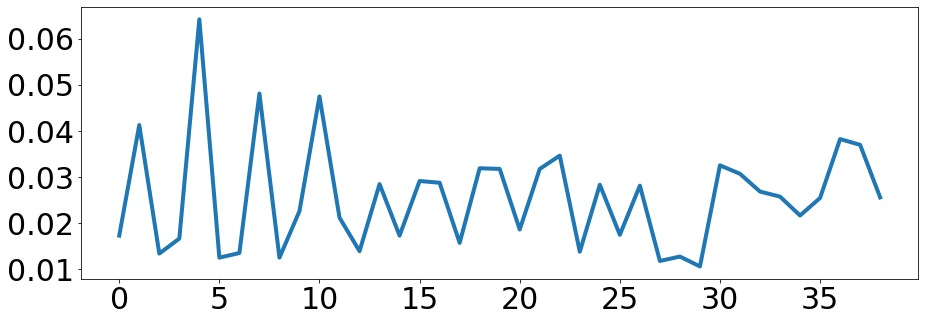

In [10]:
plt.figure(figsize=(15,5))
plt.plot(clf.feature_importances_,lw=4)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

Some features (or predictors) matter, and some don't. Throwing more and more features at a model doesn't ensure improved performance. Many times it will actually degrade performance.

# What can we do to add more useful features?

There are actually a lot of options...

# More features: Add spectral indices

These effectively combine the spectral bands from the satellite to arrive at indices that are higher quality than any given band and are more strongly connected to the problem at hand. 

# Spectral vegetation signatures

![image.png](https://eo4geo.sbg.ac.at/IGIK/Sentinel2_Data_and_Vegetation_Indices/leaf_reflectance.png)

Vegetation spectra correspond to bundles of leaves and steams of Spartina alternifora, a wetland perennial grass from Kokaly et al. (2017), Soil spectrum from Clark (1999). Figure adapted by Denis, A. (2018) from Kokaly et al. (1998), Bowker et al. (1985), Curran (1989) and Thenkabail et al. (2013). Source of image: https://eo4geo.sbg.ac.at

# Seen another way...

![image.png](https://eo4geo.sbg.ac.at/IGIK/Sentinel2_Data_and_Vegetation_Indices/plant_spectral_properties.jpeg)

Varied response of a given plant depending on the time of year. Source of image: https://eo4geo.sbg.ac.at

Spectral indices harness the spectral signatures from different land cover types to determine vegetation status, and land cover types, among others.

# Let's review some spectral indices

# RVI (Ratio vegetation index)

$$ \text{RVI} = \frac{\text{NIR}}{\text{RED}}$$

This is an example of a band ratio which is a common practice to remove effects of topography and atmospheric effects. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(-0.5, 63.5, 63.5, -0.5)

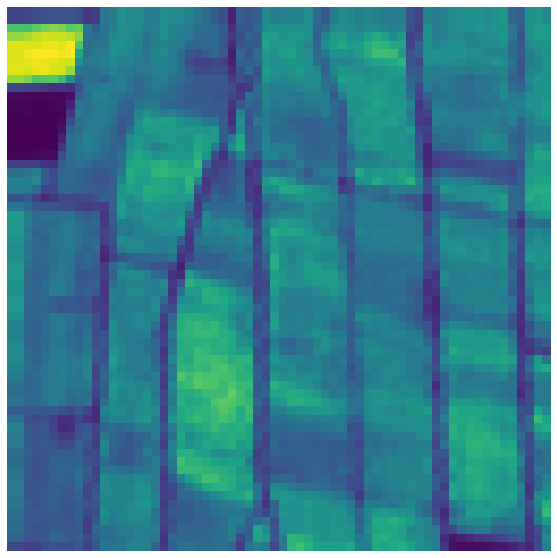

In [11]:
NIR = db['covariates']['b8']
RED = db['covariates']['b4']
RVI = (NIR)/(RED)
plt.figure(figsize=(10,10))
plt.imshow(RVI[150,:,:])
plt.axis('off')

# NDVI (Normalized difference vegetation index)

$$ \text{NDVI} = \frac{\text{NIR} - \text{RED}}{\text{NIR} + \text{RED}}$$

![image.png](https://eo4geo.sbg.ac.at/IGIK/Sentinel2_Data_and_Vegetation_Indices/NDVI_trees.png)

NDVI is effective for quantifying green vegetation. Positively correlated with vegetation greenness. There are multiple variations on NDVI such as TNDVI or NDI45.

Source: Wu Ch-D., et al. (2014)

(-0.5, 63.5, 63.5, -0.5)

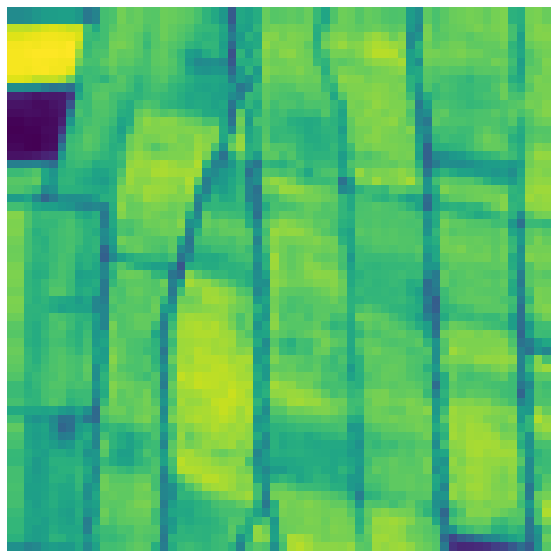

In [12]:
NIR = db['covariates']['b8']
RED = db['covariates']['b4']
NDVI = (NIR-RED)/(NIR+RED)
plt.figure(figsize=(10,10))
plt.imshow(NDVI[150,:,:])
plt.axis('off')

# GNDVI (Green normalized difference vegetation index)

$$ \text{GNDVI} = \frac{\text{NIR} - \text{GREEN}}{\text{NIR} + \text{GREEN}}$$

GNDVI is more sensitive than NDVI to different concentration rates of chlorophyll, which is highly correlated to nitrogen.

(-0.5, 63.5, 63.5, -0.5)

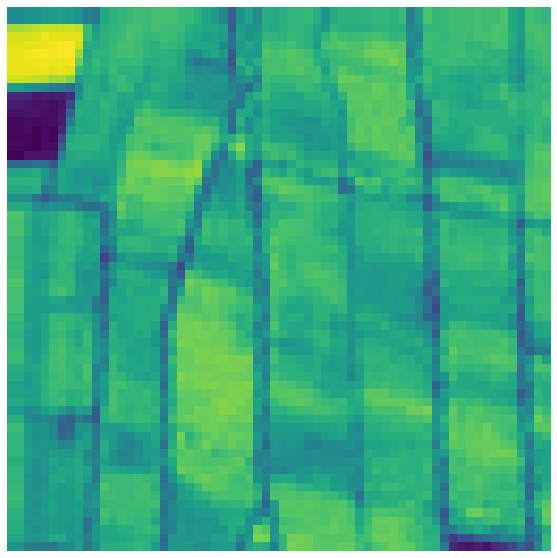

In [13]:
NIR = db['covariates']['b8']
GREEN = db['covariates']['b3']
GNDVI = (NIR-GREEN)/(NIR+GREEN)
plt.figure(figsize=(10,10))
plt.imshow(GNDVI[150,:,:])
plt.axis('off')

# IRECI (Inverted Red-Edge Chlorophyll Index)

$$ \text{IRECI} = \frac{\text{NIR} - \text{RED1}}{\text{RED2} + \text{RED3}}$$

IRECI incorporates the reflectance in four bands to estimate canopy chlorophyll content

(-0.5, 63.5, 63.5, -0.5)

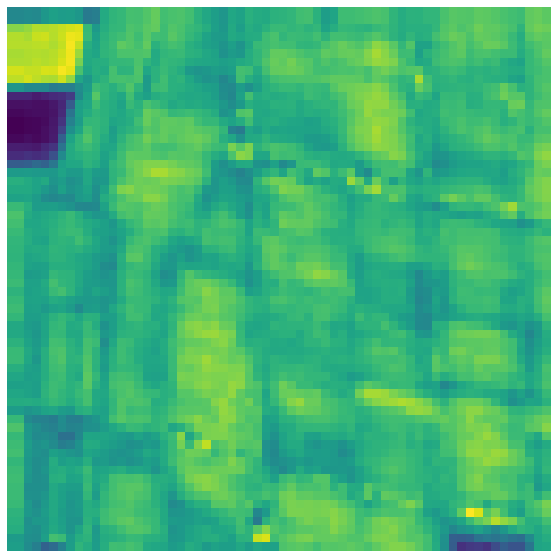

In [14]:
NIR = db['covariates']['b8']
RED1 = db['covariates']['b5']
RED2 = db['covariates']['b6']
RED3 = db['covariates']['b7']
IRECI = (NIR-RED1)/(RED2+RED3)
plt.figure(figsize=(10,10))
plt.imshow(IRECI[150,:,:])
plt.axis('off')

# SAVI (Soil Adjusted Vegetation Index)

$$ \text{SAVI} = 1.428\frac{\text{NIR} - \text{RED}}{NIR + RED + 0.428} $$

SAVI uses a transformation technique that minimizes soil brightness influences from spectral vegetation indices involving red and near-infrared (NIR) wavelengths.

(-0.5, 63.5, 63.5, -0.5)

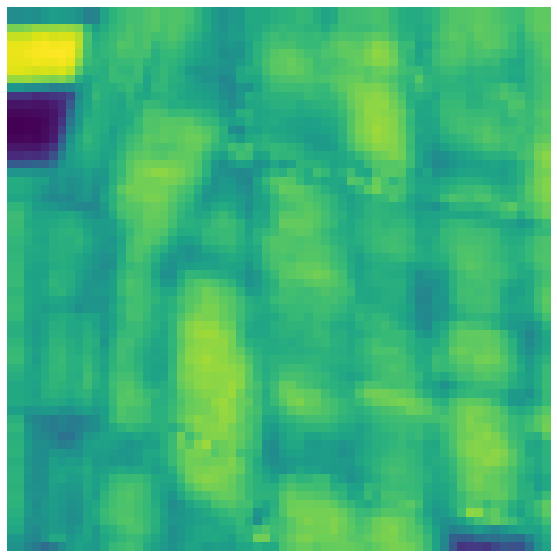

In [15]:
NIR = db['covariates']['b8']
RED = db['covariates']['b5']
SAVI = 1.428*(NIR-RED)/(NIR + RED + 0.428)
plt.figure(figsize=(10,10))
plt.imshow(SAVI[150,:,:])
plt.axis('off')

# NDMI (Normalized Difference Water Index)

$$ \text{NDMI} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}$$

NDMI describes the crop’s water stress level and is calculated as the ratio between the difference and the sum of the refracted radiations in the near infrared and SWIR.

(-0.5, 63.5, 63.5, -0.5)

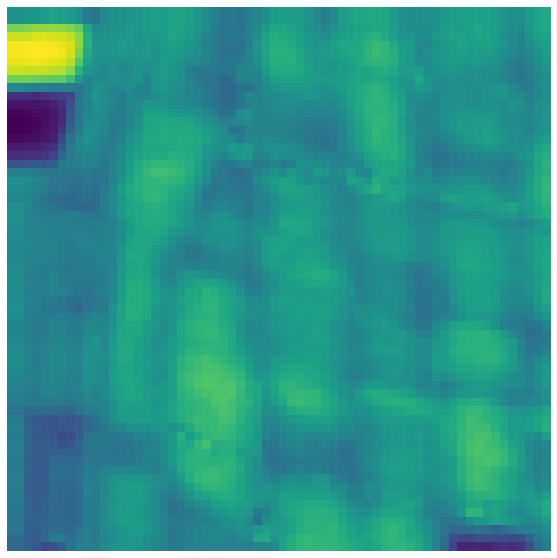

In [16]:
NIR = db['covariates']['b8']
SWIR = db['covariates']['b11']
NDMI = (NIR-SWIR)/(NIR+SWIR)
plt.figure(figsize=(10,10))
plt.imshow(NDMI[150,:,:])
plt.axis('off')

# I think you get the point...

The sensors on a satellite dictate what indices we can use. Don't fixate too much on what each index means. Sentinel-2 just has a lot of bands which makes it possible to do a lot more.

In [17]:
%%HTML
<iframe width="939" height="528" src="https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/" frameborder="0" allow="accelerometer;  autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

# Let's now add all these indices as our covariates

In [18]:
#Spatial means + variances + median dataset of everything
db['derived_covariates'] = {'NDMI':NDMI,'SAVI':SAVI,'IRECI':IRECI,'GNDVI':GNDVI,'NDVI':NDVI}
X = []
for var in db['derived_covariates']:
    print(db['derived_covariates'][var].shape)
    X.append(np.mean(db['derived_covariates'][var],axis=(1,2)))
    X.append(np.var(db['derived_covariates'][var],axis=(1,2)))
    X.append(np.percentile(db['derived_covariates'][var],50,axis=(1,2)))
for var in db['covariates']:
    print(db['covariates'][var].shape)
    X.append(np.mean(db['covariates'][var],axis=(1,2)))
    X.append(np.var(db['covariates'][var],axis=(1,2)))
    X.append(np.percentile(db['covariates'][var],50,axis=(1,2)))
X = np.array(X).T

(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)


In [19]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.83


# Making progress!!

# More features: Image processing

# Canny edge detector

(-0.5, 63.5, 63.5, -0.5)

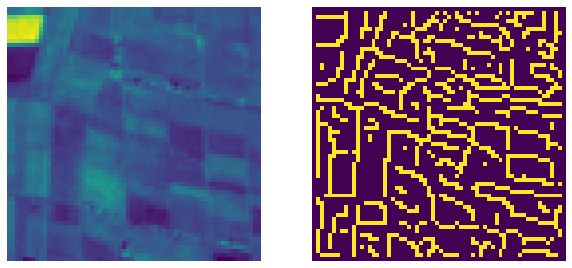

In [20]:
from skimage import feature
NIR = db['covariates']['b8']
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(NIR[150,:,:])
plt.axis('off')
plt.subplot(122)
plt.imshow(feature.canny(NIR[150,:,:],sigma=1))
plt.axis('off')

In [25]:
for var in db['covariates']:
    CANNY = []
    print(var)
    for i in range(db['covariates'][var].shape[0]):
        CANNY.append(feature.canny(db['covariates'][var][i,:,:],sigma=1))
    db['derived_covariates']['%s_CANNY' % var] = np.array(CANNY)

b1
b2
b3
b4
b5
b6
b7
b8
b9
b10
b11
b12
b13


# Ridge filters

Ridge filters can be used to detect ridge-like structures, such as neurites, tubes, vessels, wrinkles or rivers.

(-0.5, 63.5, 63.5, -0.5)

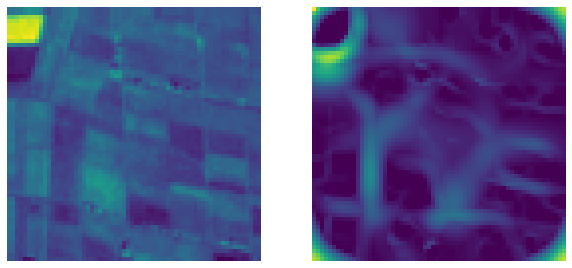

In [26]:
from skimage import filters
from skimage.morphology import disk
selem = disk(3)
NIR = db['covariates']['b8']
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(NIR[150,:,:])
plt.axis('off')
plt.subplot(122)
plt.imshow(filters.sato(NIR[150,:,:]))
plt.axis('off')

In [30]:
for var in db['covariates']:
    RIDGE = []
    print(var)
    for i in range(db['covariates'][var].shape[0]):
        RIDGE.append(filters.sato(db['covariates'][var][i,:,:]))
    db['derived_covariates']['%s_RIDGE' % var] = np.array(RIDGE)

b1
b2
b3
b4
b5
b6
b7
b8
b9
b10
b11
b12
b13


# Mean filters

(-0.5, 63.5, 63.5, -0.5)

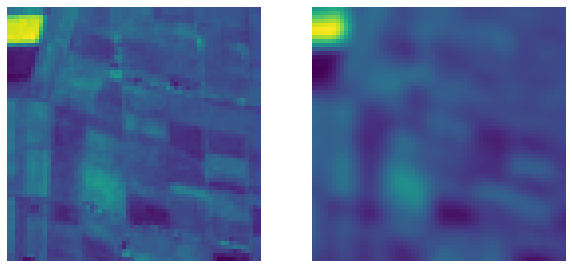

In [31]:
from skimage import filters
from skimage.morphology import disk
selem = disk(3)
NIR = db['covariates']['b8']
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(NIR[150,:,:])
plt.axis('off')
plt.subplot(122)
tmp = NIR[150,:,:]
tmp = (tmp - np.min(tmp))/(np.max(tmp) - np.min(tmp))
plt.imshow(filters.rank.mean(tmp,selem=selem))
plt.axis('off')

### And lots, lots more...

# Add some of these features to the mix

In [32]:
#Spatial means + variances + median dataset of everything
X = []
for var in db['derived_covariates']:
    print(db['derived_covariates'][var].shape)
    X.append(np.mean(db['derived_covariates'][var],axis=(1,2)))
    X.append(np.var(db['derived_covariates'][var],axis=(1,2)))
    X.append(np.percentile(db['derived_covariates'][var],50,axis=(1,2)))
for var in db['covariates']:
    print(db['covariates'][var].shape)
    X.append(np.mean(db['covariates'][var],axis=(1,2)))
    X.append(np.var(db['covariates'][var],axis=(1,2)))
    X.append(np.percentile(db['covariates'][var],50,axis=(1,2)))
X = np.array(X).T

(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)
(1000, 64, 64)


In [34]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.835


# Progress?

In [35]:
X.shape

(1000, 132)

(array([-0.005,  0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ]),
 <a list of 8 Text yticklabel objects>)

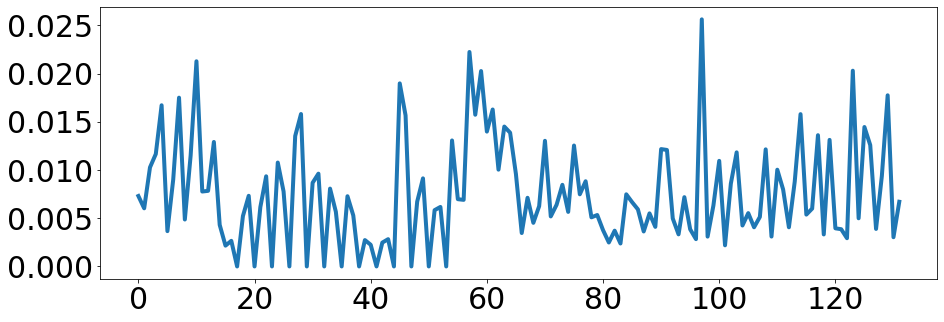

In [36]:
plt.figure(figsize=(15,5))
plt.plot(clf.feature_importances_,lw=4)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

* What's wrong here? 

# Recursive Feature Elimination

Iteratively fit a model and remove features. Features are removed based on their feature importance.

In [40]:
from sklearn.feature_selection import RFE
estimator = RandomForestClassifier(random_state=0,n_estimators=100)
clf = RFE(estimator, n_features_to_select=25,step=5,verbose=True)
clf = clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
0.835


Although it didn't do much here beyond reducing the number of features, sometimes it can help with model performance. 

# Dimensionality reduction: Principal Component Analysis

In [46]:
import sklearn.decomposition
#Standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
Xstd = scaler.transform(X)
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=100)
#Fit the model
pca.fit(Xstd)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

# PCA: Explained variance

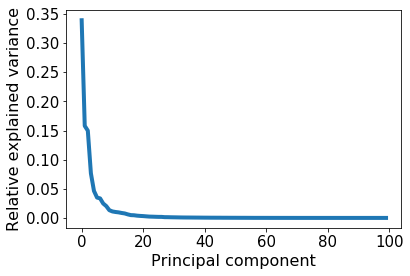

In [48]:
#Explained variance
plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),lw=4)
plt.ylabel('Relative explained variance',fontsize=16)
plt.xlabel('Principal component',fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Let's only keep the top 20 principal components

In [93]:
#Define the parameters
pca = sklearn.decomposition.PCA(n_components=20)
#Fit the model
pca.fit(Xstd)
#Transform the data
PCS = pca.transform(Xstd)
#Inverse transform the data
Xpred_std = pca.inverse_transform(PCS)

# Random Forest on the 20 PCs

In [94]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(PCS, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.815


# Random Forest on the inversely transformed PCs

In [95]:
clf = RandomForestClassifier(random_state=0,n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(Xpred_std, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print('Classification accuracy:',clf.score(X_test,y_test))

Classification accuracy: 0.865


PCA effectively de-noised the data and thus improves predictability!

# Conclusions...

* We started at an accuracy of 0.7 and ended at 0.865. So it was not a waste of time!
* Finding the right features and figuring out how to leverage them can get very tricky. 
* Word of advice: Don't start massaging your data until you are already in the ballpark of your target accuracies. At the end of the day, if you have the right model and the right features, feature engineering and selection will be a second-order problem. It is fun but it can also lead nowhere.
* Wouldn't it be nice if an algorithm did all this feature engineering for me? That is in essence what convolutional neural networks are doing for us (we will talk about it on Thursday). 